# Dataset preparation

In this section MNIST dataset is used. I define [here](https://github.com/JackVittori/QML-early_exit/blob/main/data_utils.py) a class in order to preprocess it and select the labels you want. 

In [1]:
import torch
import pennylane as qml
from pennylane import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from data_utils import mnist_preparation 
from tqdm import tqdm
import matplotlib as plt
from OriginalModel import FullQuantumModel, QuantumCircuit
from pennylane import Device
from pennylane.measurements import StateMP
from torch.nn import Module, ParameterDict
import matplotlib.pyplot as plt
import warnings
from typing import Optional, Dict, List, Any
from torch.utils.data import DataLoader
from time import time
import math

# Theory: Pure and mixed states
In simple terms, a state is **pure** if you do not have ignorance about its preparation while it is **mixed** if you do not know. The so called **density operator**, is a useful tool to describe quantum states especially when they are mixes and can be defined as:

$$
\hat{\rho} = \sum \limits_i p_i | \phi_i \rangle \langle \phi_i |
$$ 

where the probabilities $\sum \limits_i p_i = 1$ and each of $p_i$ is associated to state $|\phi_i \rangle$. The density operator is useful to describe mixed states. For a pure state instead you will have the probability being 1 in a specific state ending up in $\hat{\rho} = | \phi \rangle \langle \phi |$. 

The density operator can be represented as a matrix using the basis $\{ |i \rangle \}_{i=1}^{2^N}$, where N is the number of qubits, then the ij-th element of the matrix will be $\langle i | \rho | j \rangle$. In matrix representation on the diagonal there are the so called *population terms* and off diagonal the *coherence terms*.

The density operator: 
- is hermitian, meaning that on the diagonal $\rho_{ii} = \rho_{ii}^*$ and off diagonal $\rho_{ij}= \rho{ji}^*$;
- has unitary trace $\text{tr}[\rho] = 1$; 
- is non negative, i.e. for any vector in the Hilbert space $\langle \phi |\rho | \phi \rangle \geq 0$. 

A simple criterion to check if a state is pure or mixed is to calculate $\text{tr}[\rho^2]$, if it is 1 it is pure, if it is less than 1 it is mixed.



# Overview of the original model
The original model has been given in a .ipynb file that can be consulted [here](https://github.com/JackVittori/QML-early_exit/blob/main/PQC_MNIST_classifier.ipynb), but I decided to rearrange it in a [class](https://github.com/JackVittori/QML-early_exit/blob/main/OriginalModel.py) adding some useful methods as to freeze and unfreeze weights and to train up to a certain layer. 
 
The initial state of the system is initialized using one image. If the image is of size 16x16, then you need 8 qubits in order to have $2^8 = 256$ possible states in order to associate each of the 256 values referred to an image to define the amplitude to be in a specific state (obviously they need to be normalized in order to have that the sum of square modulo of the weights to be 1). In PennyLane, the states are in lexiographic order, whose meaning is hereafter reported for completeness:  

 

In [2]:
#lexiographic order
states = []
for i in range(256):
    states.append(format(i, '08b'))  
print(states)

['00000000', '00000001', '00000010', '00000011', '00000100', '00000101', '00000110', '00000111', '00001000', '00001001', '00001010', '00001011', '00001100', '00001101', '00001110', '00001111', '00010000', '00010001', '00010010', '00010011', '00010100', '00010101', '00010110', '00010111', '00011000', '00011001', '00011010', '00011011', '00011100', '00011101', '00011110', '00011111', '00100000', '00100001', '00100010', '00100011', '00100100', '00100101', '00100110', '00100111', '00101000', '00101001', '00101010', '00101011', '00101100', '00101101', '00101110', '00101111', '00110000', '00110001', '00110010', '00110011', '00110100', '00110101', '00110110', '00110111', '00111000', '00111001', '00111010', '00111011', '00111100', '00111101', '00111110', '00111111', '01000000', '01000001', '01000010', '01000011', '01000100', '01000101', '01000110', '01000111', '01001000', '01001001', '01001010', '01001011', '01001100', '01001101', '01001110', '01001111', '01010000', '01010001', '01010010', '01

Considering that $\text{dim}\mathcal{H}_8 = 2^8$, that the computational basis for an 8-qubit system is $\{ |00000000\rangle, |00000001 \rangle, \dots, |11111111 \rangle \}$ and can be synthetically expressed as $\{ |i \rangle \}_{i = 1}^{2^8}$, the general initial state can be expressed as: 

$$
|\psi \rangle = \sum \limits_{i=1}^{256} \alpha_i |i \rangle
$$

where $\alpha_i$ are complex coefficients such that $\sum \limits_{i=1}^{256} \alpha_i = 1$. 

Each layer of the original model consists in parametrized rotations defined using the $\sigma_X, \sigma_Y, \sigma_Z$ Pauli Matrices [RX](https://docs.pennylane.ai/en/stable/code/api/pennylane.RX.html), [RY](https://docs.pennylane.ai/en/stable/code/api/pennylane.RY.html), [RZ](https://docs.pennylane.ai/en/stable/code/api/pennylane.RZ.html) gates applied on each qubit, then [CNOT](https://docs.pennylane.ai/en/stable/code/api/pennylane.CNOT.html) gates are applied to create entanglement. **CNOT** is a 2 qubit gate with a *control* and a *target* qubit (if the control is $|1\rangle$ swap the target qubit). Then suppose to apply a CNOT gate on a two qubit state in the form $(\alpha |0\rangle_A + \beta |1\rangle_A)|0\rangle_B$ you will obtain the entangled state $\alpha|00\rangle_{AB} + \beta |11\rangle_{AB}$.

A very small recap on entanglement is hereafter reported. Considering a system composed by two subsystems A,B, for pure states it can be described by $|\phi \rangle_{AB}$. Then the state is **separable** iff: 

$$
$|\phi \rangle_{AB}$ = |\phi \rangle_A \otimes |\phi \rangle_B
$$

For example $\frac{|00\rangle_{AB} + |01 \rangle_{AB}}{\sqrt{2}$ is separable beacuse it can be written as $\frac{|0\rangle_{A} (|0\rangle_{B} + |1 \rangle_{B})}{\sqrt{2}$.

If the state is not separable it is **entangled**. This fact is not easy to prove, for this reason there exists some criteria working under specific circumstances that I do not specify there but can be consulted in Nielsen Chuang or Principles of Quantum computation Vol 1,2 of Benenti Casati Strini.
 
One example of Entangled states are the [Bell states](https://en.wikipedia.org/wiki/Bell_state), that can be used as a basis of Entangled Hilbert Space.

For mixed states instead we can use an operational approach to express **separability** called Local Operation and Classical Communication. A and B, prepare separable states locally and cooperate with classical communication to create the full state: 

$$
\rho_{AB} = \sum \limits_i p_i \rho_A^i \otimes \rho_B^i
$$

Also there if a state is not separable, then it is **entangled** and there exists some criteria that make use of Von Neumann Entropy or other tool to check if the state is entangled.

## Original Model Implementation
Refer to [this implementation](https://github.com/JackVittori/QML-early_exit/blob/main/initial-model.py) for the original model where you can use the methods that I defined to freeze/unfreeze the weights of each layer, draw the circuit, put early exits and train (also with some fixed layers) with any number of classes you want. The logic was simple: 

- 2 classes: use the first qubit for classification, the first 128 states of the state vector refer to $|0\rangle$ state, the last 128 to $|1\rangle$ state. Use BCE loss to train and probability as confidence measure for early exits. 
- 3 classes: use two qubits for classification, then you will have 4 possible states $|00\rangle, |01\rangle, |10\rangle, |11\rangle$. Use the first 3 states for classification, the output probabilities will be used as logits (has having 4 states they will not sum up to one) and the model will be train with CrossEntropy Loss (that have a softmax activation). The probability is used as confidence measure for early exits; 
- 4 classes: use two qubits for classification, then the output probabilities are effectively probabilities and the model is trained using Negative Log Likelihood. The probability is used as confidence measure for earl exits. 

In general considering to use 8 qubits for the model in order to *load* 256 image pixel values, a number of classification qubits is calculated as `math.ceil(math.log2(num_classes))` and Log Likelihood or Cross Entropy is selected automatically by the class FullQuantumModel on initialization to train. An example of how to use and train the model with also early exits is reported [here](https://github.com/JackVittori/QML-early_exit/blob/main/main.ipynb). Hereafter is reported a schematic representation of the original model:


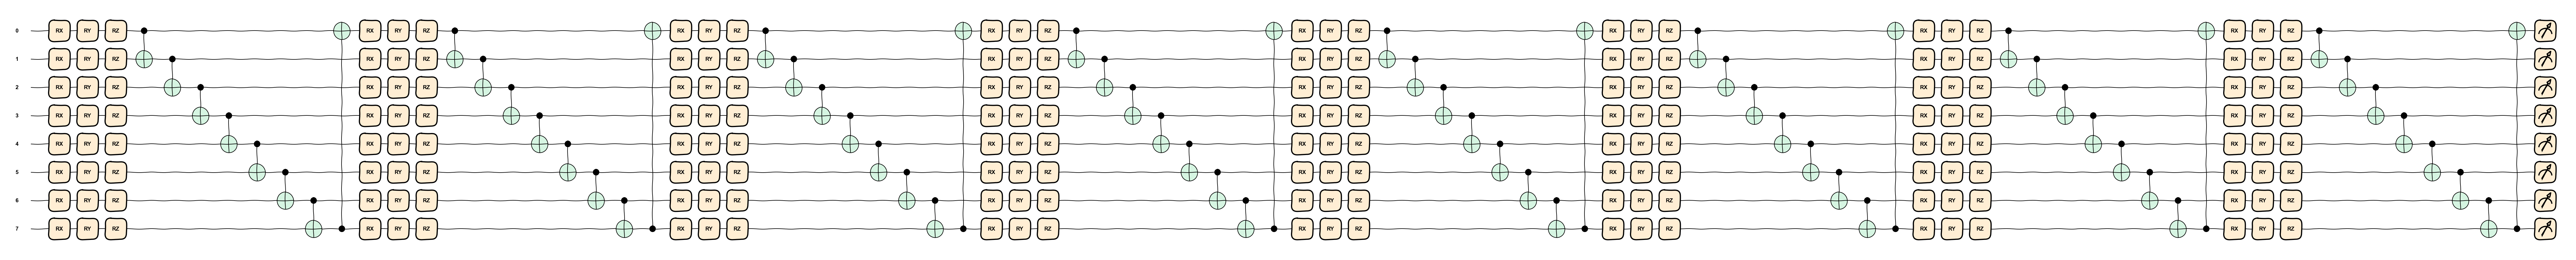

Trainable parameters: 192


In [3]:
num_qubits = 8
num_layers = 8
model = FullQuantumModel(qubits=num_qubits, layers=num_layers, num_classes=4)
model.draw(style = 'sketch')
model.trainable_parameters()

The number of trainable parameters are 24 per layer, 1 parameter per rotation, 3 rotations per qubit, 8 qubits in total.

# Mid circuit measurements model

For simplicity, suppose we want to perform classification on 4 classes. 

We can associate label 0,1,2,3 to states $|00 \rangle, |01 \rangle, |10 \rangle, |11 \rangle$. The idea for early exits is to measure the first pair of qubits for the first exits, the second pair of qubits for the second, the third pair of qubits for the third and the last pair of qubits for the last one. Maybe we could also reduce the number of exits to 2 or 3 instead of 4, we'll see. Given that a measurement affect the state of the system, we need to explore a bit the theory behind mid circuit measurements.

# Mid circuit measurements
A [measurement](https://pennylane.ai/qml/demos/tutorial_mcm_introduction/) $M$ is a process that maps a valid quantum state $\rho$ (density operator) to a classical probabilistic mixture of post measurement quantum states $\rho_i$, specified by $M$: 

$$
M[\rho] = \sum \limits_{i=1}^n p_i \rho_i
$$

where $n$ is the number of possible outcomes and $p_i$ the probability to measure outcome $i$ associated to $\rho_i$. This describes the probabilistic mixture after the measurement if we do not record the outcome. If the outcome is recorded, we no longer have a probabilistic mixture but the state $\rho_i$ associated to the filtered outcome $i$. 

Considering the so called projective measurements, calling $\Pi_i$ the projector associated to the measurement outcome, with all projectors summming to the identity, the post measurement states are given by: 

$$
\rho_i = \frac{\Pi_i \rho \Pi_i}{\text{tr}[\Pi_i \rho]}
$$

where $p_i = \text{tr}[\Pi_i \rho]$. If we do not measure the outcome the system will end up in state: 

$$
M[\rho] = \sum \limits_{i=1}^n \Pi_i \rho \Pi_i
$$

## Theory addendum: Generalized Quantum Measurements

Generalized measurements are a collection of operators $\{ M_i\}$ such that for pure states the probability of the measurement outcome $i$ is given by:

$$
p(i) = \langle \psi | M_i^{\dagger} M_i | \psi \rangle
$$

The state of the system after the measurement, given that the outcome $i$ was obtained, is:

$$
|\psi'\rangle = \frac{M_i |\psi\rangle}{\sqrt{\langle \psi | M_i^{\dagger} M_i | \psi \rangle}}
$$

For mixed states instead the probability of the measurement outcome $i$ is given by: 
$$
p(i) = \text{tr}[\rho M_i^{\dagger} M_i]
$$

The state of the system after the measurement, given that the outcome $i$ was obtained, is:

$$
\rho' = \frac{M_i^{\dagger} \rho M_i}{\text{tr}[\rho M_i^{\dagger} M_i]}
$$

From that, we can define the so called **Positive Operator Valued Measurements (POVM)** as $\Pi_i=M_i^\dagger M_i$ where $\sum \limits_i \Pi_i = \mathbf{I}$. They are non negative and for pure states the probability of obtaining outcome $i$ is $p(i)= \langle \psi |\Pi_i |\psi \rangle$, while for mixed state is $p(i) = \text{tr}[\rho \Pi_i]$. 

The **projective measurements** are a specific class of Generalized Measurements  where $P_i = | i \rangle  \langle i |$, $\sum_i P_i = \mathbf{I}$, $P_iP_j = \delta_{ij} P_i$ and $P_i^2 = \mathbf{I}$. In this case for pure states the probability of obtaining outcome $i$ is: 

$$
p(i) = \langle \psi |P_i| \psi \rangle
$$

and the final state is: 

$$
|\psi' \rangle = \frac{P_i |\psi \rangle}{ \sqrt{\langle \psi |P_i| \psi \rangle}}
$$

For mixed state the probability to obtain an outcome $i$ is given by: 

$$
p(i) = \text{tr}[\rho P_i]
$$

And the final state: 

$$
\rho' = \frac{P_i \rho P_i}{\text{tr}[\rho P_i]}
$$

In PennyLane, the measurements with unknown outcomes are [Measurement Value](https://docs.pennylane.ai/en/stable/code/api/pennylane.measurements.MeasurementValue.html) objects. 

## Mid-circuit-Measurements model

In our model we would like to register the outcome of each mid circuit measurements of two qubits to be used for classification of the input image in each early exits, then the resulting state will not be in a probabilistic mixture but will be the one $\rho_i$ associated to the outcome $i$. 

How can we measure the confidence associated to classification at each step?

### First approach: 

Access to the probabilities associated to the measured state and use the highest probability between the 4 as confidence measure of the correspondent predicted label for the input image. In simulation, the circuit is run a number of *shots* specified in the [`device`](https://docs.pennylane.ai/en/stable/code/api/pennylane.device.html) definition. In general, supposing to take measurements using [`qml.sample()`](https://docs.pennylane.ai/en/stable/code/api/pennylane.sample.html), it will return as many samples as specified in the shots argument. With an high enough number of samples, the result can be used to estimate the probability to obtain a specific outcome for that. In practice it will be more useful to use directly [`qml.probs()`](https://docs.pennylane.ai/en/stable/code/api/pennylane.probs.html) with `op` argument the sequence of `MeasurementValue` objects coming from mid circuit measurements. 

(In inference would we need a single shot classification or we can assume that we can repeat for a given number of times the computation? I think that the assumption is always that the circuit is run multiple times, otherwise it would be impossible to estimate a quantum state with one shot. In fact to access to a state in one shot through PennyLane I think that can be considered 'cheating'.)

### Second approach:

The second approach is to use the [fidelity](https://en.wikipedia.org/wiki/Fidelity_of_quantum_states) to quantify the confidence associated to a given output. 

**Theory: Fidelity Measure**

The fidelity (square root fidelity) is a 'distance' measure between quantum states that for arbitrary states (defined through density operators) is defined as: 

$$
F(\rho, \sigma) = \text{tr}^2[ \sqrt{\rho^{\frac{1}{2}} \sigma \rho^{\frac{1}{2}}}]
$$

If $\rho$ and $\sigma$ commute, i.e. when they are diagonal in the same basis: $\rho = \sum \limits_i r_i |i\rangle \langle i|$ and $\sigma = \sum \limits_i s_i |i\rangle \langle i|$ for some orthonormal basis, the fidelity reduces to: 

$$
F(\rho, \sigma) = \sum \limits_i r_i s_i
$$


The fidelity between a pure state $|\psi \rangle$ and an arbitrary state $\rho$ is given by: 

$$
F(\rho, |\psi\rangle) = \langle \psi|\rho |\psi \rangle
$$

That is the square root of the overlap between them. 

Finally, the fidelity between two pure states $|\phi\rangle, |\psi\rangle$: 

$$
F(|\phi\rangle, |\psi\rangle) = |\langle \phi|\psi\rangle|^2
$$

For example, $F(\frac{|0\rangle \langle 0| + |1\rangle \langle 1|}{2}, |0\rangle) = \frac{1}{2}$, $F(|0\rangle,|0\rangle) = 1$, $F(|0\rangle,|1\rangle) = 0$, $F(|+\rangle,|0\rangle) = \frac{1}{2}$.

In general the value of the fidelity is comprised between 0 and 1 (the higher the similar). 


### Fidelity measurements for classical estimation

From the course in Quantum Information I learned that fidelity can be used to assess the quality of a **classical estimation** of a quantum state. Suppose Alice want to communicate a pure state to Bob $|\psi \rangle = \alpha |0\rangle + \beta |1 \rangle$ <u>without</u> a quantum channel. Imagine that you have infinite copies of the quantum state, Alice can measure his state in the computational basis and communicate the outcomes classically to Bob. Bob can then can characterize the quantum system (with some limitations) proposing a $\hat{\rho}_G$ guess whose quality will depend on the quantity of transferred information and can be measured using the fidelity.

In general, we can not directly access to a quantum state. What we can do is to run the circuit many times obtaining a number of outputs given by the number of `shots` specified in the device initialization. Using [`qml.probs()`](https://docs.pennylane.ai/en/stable/code/api/pennylane.probs.html) with a given number of shots, we are extracting our guess from the sampling process, whose "closeness" to the four vectors of the computational basis can be evaluated using fidelity.

In order to perform a Mid Circuit Measurement PennyLane suggests to use [`qml.measure()`](https://docs.pennylane.ai/en/stable/code/api/pennylane.measure.html)

### Application:

Having 4 classes, they can be associated to states $|00\rangle, |01\rangle, |10\rangle,|11\rangle$. Our aim is to have as output a state that have the higher possible fidelity, i.e. we want the state before the measurement to be as close as possible to one of the fourth basis vectors. Then the fidelity could be used as a confidence measure in the classification at each early exits setting a threshold: 

1. Measure the first 2 qubits -> classification, if the fidelity is high enough we can stop here, otherwise continue; 
2. Measure the second pair of qubits -> classification, if the fidelity is high enough we can stop here, otherwise continue; 
3. Repeat for how many early exits have you put, if the fidelity is never adequately high take the output of all the layers.

## Pennylane measurement

According to [Pennylane](https://pennylane.ai/blog/2022/06/how-to-do-measurements-in-pennylane/), in real experiment the actual wave function is not accessible but we can "cheat" taking as output a set of measurement from the resulting state. There exists some function in Pennylane in order to do that: 

- [`qml.sample()`](https://docs.pennylane.ai/en/stable/code/api/pennylane.sample.html) is used to output a number of samples specified in the *device* definition (shots param) of the indicated observable, such as `qml.sample(qml.PauliY(0))`. Basically, Pennylane is sampling the eigenvalues $\lambda_i$ with their associated probabilites $p(\lambda_i)=|\langle \xi_i |\psi\rangle|^2$, where $|\xi_i\rangle$ is the corresponding basis state in the basis of observables. In the case we want to measure one of the four possible basis in our example the basis will be the computational one with 0,1 eigenvalues. Since it is a stochastich process it is **not differentiable**. 
- [`qml.probs()`](https://docs.pennylane.ai/en/stable/code/api/pennylane.probs.html) return an array in lexiographic order containing the probabilities $|\langle i | \psi \rangle|^2$ of measuring the computational basis state $|i\rangle$ in the current state $|\psi \rangle$ if no observable are specified. Specifying the number of `shots` in the device definition the function will output <u> the probabilities given by the sampling process</u>. Then, with an high enough number of samples we can assume we are able to reconstruct the quantum state. 

Following the example provided in [this PennyLane tutorial](https://pennylane.ai/qml/demos/tutorial_how_to_collect_mcm_stats/) that is hereafter reported, we can try to adapt the reasoning to our model...

Probability vector of first qubit MCM: [0.8 0.2]
Bit string counts on other qubits: {'000': 71, '011': 8, '100': 9, '111': 12}


/opt/homebrew/Caskroom/miniforge/base/envs/qml/lib/python3.11/site-packages/pennylane/drawer/mpldrawer.py:581: UserWarning: Glyph 10217 (\N{MATHEMATICAL RIGHT ANGLE BRACKET}) missing from font(s) Arial.
  bbox = text_obj.get_window_extent(renderer)
/opt/homebrew/Caskroom/miniforge/base/envs/qml/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 10217 (\N{MATHEMATICAL RIGHT ANGLE BRACKET}) missing from font(s) Arial.
  func(*args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/qml/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10217 (\N{MATHEMATICAL RIGHT ANGLE BRACKET}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


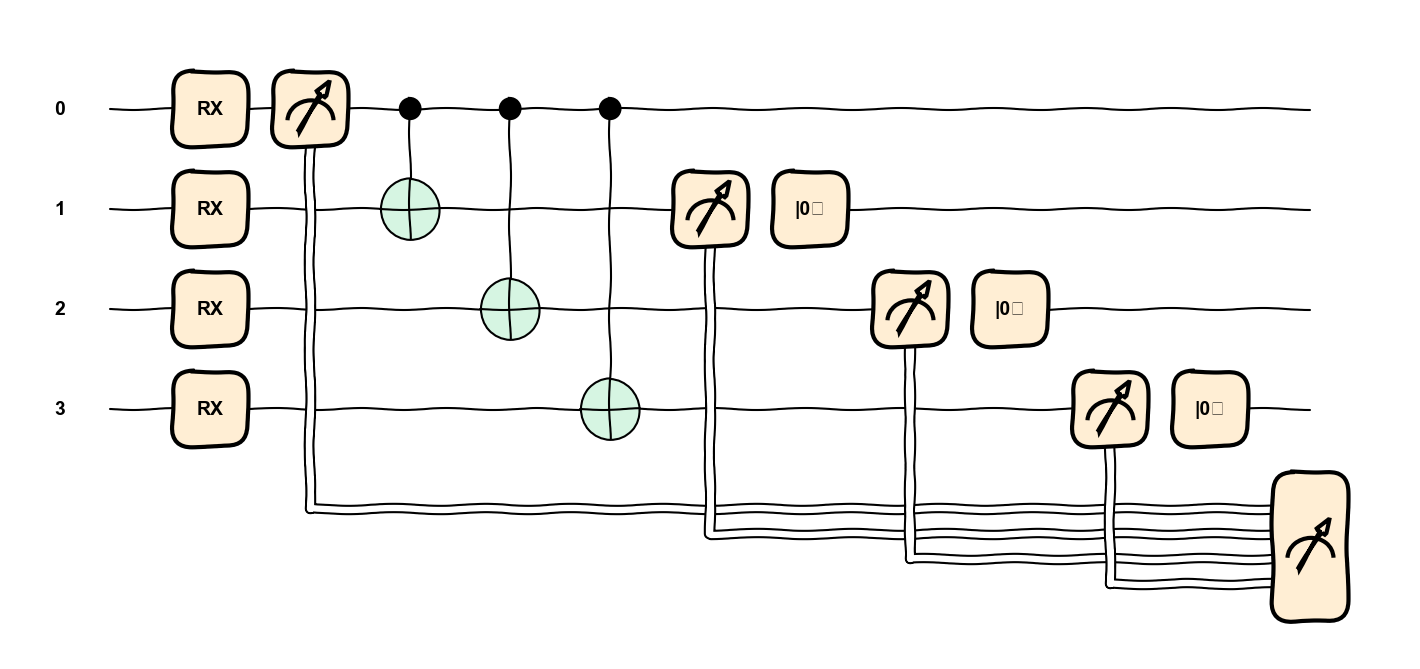

In [4]:
"""Pennylane example """

np.random.seed(511)

first_wire = 0
other_wires = [1, 2, 3]

def ansatz(x):
    mcms = []

    # Rotate all qubits
    for w, x_ in enumerate(x):
        qml.RX(x_, w)

    # Measure first qubit
    mcms.append(qml.measure(first_wire))

    # Entangle all qubits with first qubit
    for w in other_wires:
        qml.CNOT([first_wire, w])

    # Measure and reset all qubits but the first
    for w in other_wires:
        mcms.append(qml.measure(w, reset=True))

    return mcms

dev = qml.device("default.qubit", shots=100)
@qml.qnode(dev)
def simple_node(x):
    # apply the ansatz, and collect mid-circuit measurements. mcm1 is the measurement
    # of wire 0, and mcms2 is a list of measurements of the other wires.
    mcm1, *mcms2 = ansatz(x)
    return qml.probs(op=mcm1), qml.counts(mcms2)

x = np.random.random(4)
fig, ax = qml.draw_mpl(simple_node)(x)
probs, counts = qml.defer_measurements(simple_node)(x)
print(f"Probability vector of first qubit MCM: {np.round(probs, 5)}")
print(f"Bit string counts on other qubits: {counts}")

[**Defer Measurements**](https://docs.pennylane.ai/en/stable/code/api/pennylane.defer_measurements.html) are used to speed up the circuit execution. According to Nielsen Chuang, measurement can always be moved from an intermediate stage of a quantum circuit to the end of the circuit; if the measurement results are used at any stage og the circuit then classically controlled operations can be replaced by conditional quantum operation. 

# Ansatz of the model 

Let's consider 4 classes for the original model without early exits... 


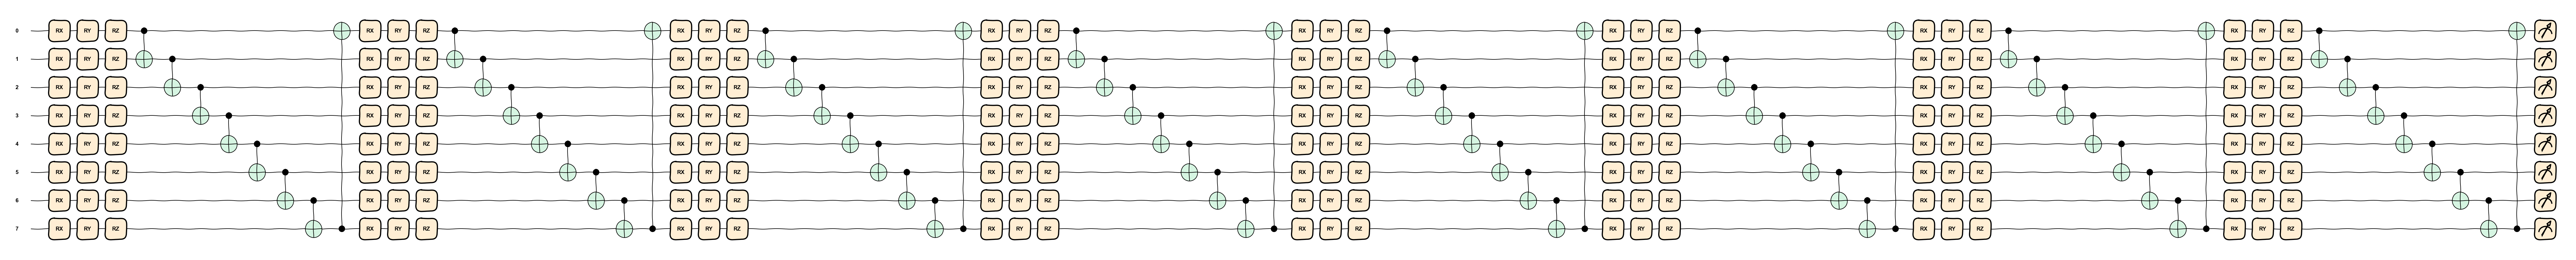

In [5]:
model.draw(style = 'sketch')

In [6]:
#dataset preparation

labels = [0,1,2,3]
# Download MNIST and prepare transforms
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([
                                transforms.Resize((16, 16)),  # Resize to 16x16
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))  # Normalize
                             ]))
#train/test 80/20 split, see data_utils.py for further details
train_dataloader, test_dataloader = mnist_preparation(dataset=mnist, labels = labels, train_test_ratio=0.8,batch_size=64)

print("Images in the training set: ", len(train_dataloader.dataset), "\n Images in the test set: ", len(test_dataloader.dataset))

Images in the training set:  19803 
 Images in the test set:  4951


In [7]:
#check all layers are set as trainable
model.trainable_layers()

{'layer_0': True, 'layer_1': True, 'layer_2': True, 'layer_3': True, 'layer_4': True, 'layer_5': True, 'layer_6': True, 'layer_7': True}


In [8]:
#We could freeze a layer if we want with the following method of the class in OriginalModel.py
model.freeze_layers([0,1])
model.trainable_layers()
model.trainable_parameters()

{'layer_0': False, 'layer_1': False, 'layer_2': True, 'layer_3': True, 'layer_4': True, 'layer_5': True, 'layer_6': True, 'layer_7': True}
Trainable parameters: 144


In [9]:
# We can also unfreeze them
model.unfreeze_layers([0,1])
model.trainable_layers()
model.trainable_parameters()

{'layer_0': True, 'layer_1': True, 'layer_2': True, 'layer_3': True, 'layer_4': True, 'layer_5': True, 'layer_6': True, 'layer_7': True}
Trainable parameters: 192


## Training of the original model

Epoch 1/5: 100%|██████████| 309/309 [00:18<00:00, 16.90it/s, accuracy=0.891, loss=1.05]


Time per epoch:  18.298680067062378
Epoch:  1 Loss:  1.1956128634295418
Accuracy:  0.718092637540453
--------------------------------------------------------------------------


Epoch 2/5: 100%|██████████| 309/309 [00:17<00:00, 17.17it/s, accuracy=0.828, loss=1.02] 


Time per epoch:  17.998188018798828
Epoch:  2 Loss:  1.0161074027660209
Accuracy:  0.895529935275081
--------------------------------------------------------------------------


Epoch 3/5: 100%|██████████| 309/309 [00:17<00:00, 17.43it/s, accuracy=0.875, loss=0.995]


Time per epoch:  17.73365306854248
Epoch:  3 Loss:  0.9768045646858833
Accuracy:  0.9107504045307443
--------------------------------------------------------------------------


Epoch 4/5: 100%|██████████| 309/309 [00:17<00:00, 17.39it/s, accuracy=0.953, loss=0.902]


Time per epoch:  17.771041870117188
Epoch:  4 Loss:  0.9537578317725542
Accuracy:  0.9183353559870551
--------------------------------------------------------------------------


Epoch 5/5: 100%|██████████| 309/309 [00:17<00:00, 17.43it/s, accuracy=0.969, loss=0.916]


Time per epoch:  17.72730278968811
Epoch:  5 Loss:  0.9365410623426962
Accuracy:  0.9266282362459547
--------------------------------------------------------------------------


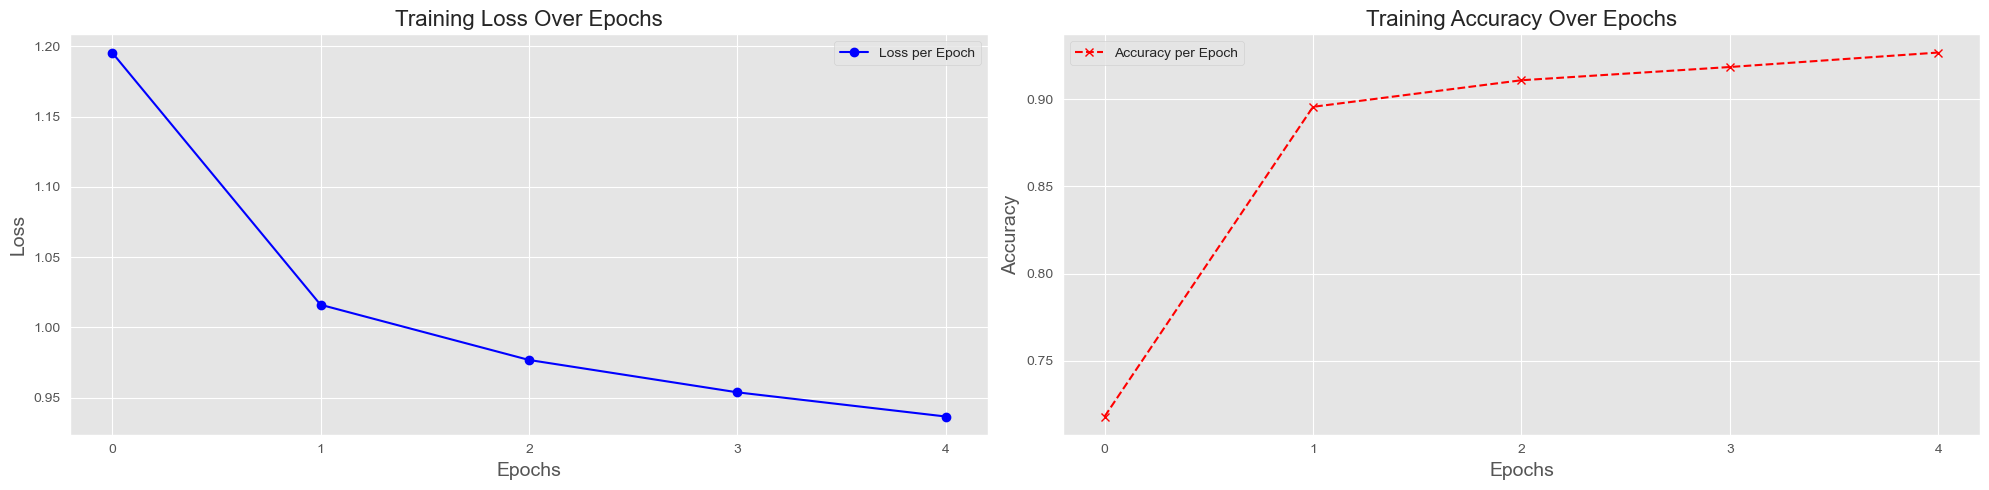

In [10]:
"""Let's proceed with training using the fit method defined in the class in OriginalModel.py
    In this case, I will use the standard training loop over the whole model."""
accuracy, loss = model.fit(dataloader=train_dataloader, learning_rate=0.001, epochs=5, show_plot=True)

## Test of the original model

In [11]:
model.freeze_layers([0,1,2,3,4,5,6,7])
model.trainable_parameters()

#simplified per image test set evaluation
result = []
for img, label in tqdm(test_dataloader.dataset):
    img = img / torch.linalg.norm(img).view(-1, 1) #image normalization
    probs = model.forward(state=img) #extract probabilities
    prediction = torch.argmax(probs, dim=1) 
    result.append((prediction, label))

Trainable parameters: 0


100%|██████████| 4951/4951 [01:24<00:00, 58.49it/s]


In [12]:
def calculate_accuracy(data):
    correct = sum([1 for label, prediction in data if label == prediction])
    return correct, correct / len(data)

test_results = calculate_accuracy(result)

print(test_results[0], "elements have been correctly classified over", len(test_dataloader.dataset), "total images with an accuracy of ", test_results[1])

4608 elements have been correctly classified over 4951 total images with an accuracy of  0.930721066451222


# Mid circuit measurements ansatz

Let's start with only one mid circuit measurement in the middle of the circuit after 4 layers...

The first pair of qubits will be used for the mid circuit measurement and the second pair for the final classification...  

In [13]:
import pennylane as qml
from pennylane import numpy as np
import torch
from typing import Dict
num_qubits = 8
num_layers = 8
params = torch.nn.ParameterDict({
            f'layer_{i}': torch.nn.Parameter(torch.rand(num_qubits, 3, requires_grad=True))
            for i in range(num_layers)
        })

#np.random.seed(511)

In [14]:
params['layer_0'] 

Parameter containing:
tensor([[0.4261, 0.2901, 0.2182],
        [0.3468, 0.0153, 0.5745],
        [0.2469, 0.1325, 0.7225],
        [0.5613, 0.9696, 0.6304],
        [0.3145, 0.7865, 0.1791],
        [0.3808, 0.8142, 0.2061],
        [0.2700, 0.8691, 0.4821],
        [0.7179, 0.9635, 0.1261]], requires_grad=True)

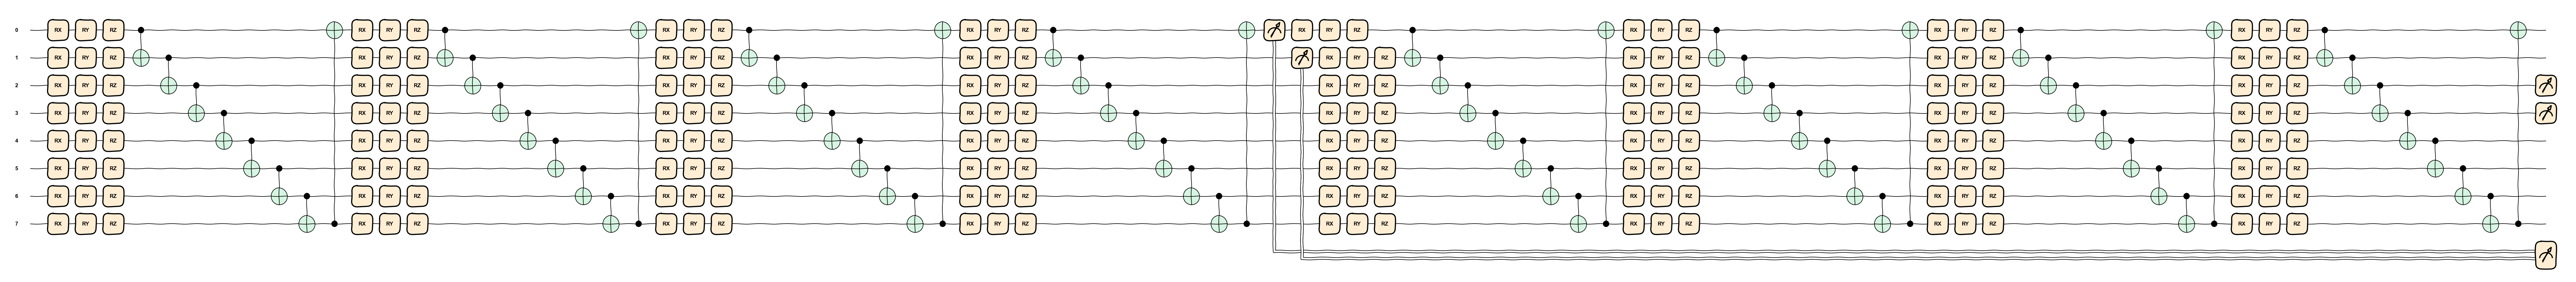

In [16]:
first_pair = [0,1]
second_pair = [2,3]


def ansatz(parameters: Dict, state: torch.Tensor = None): 
    
    if state is not None: 
        # state vector initialization with input
        qml.QubitStateVector(state, wires=range(num_qubits))
        
    for i in range(4): 
        for j in range(num_qubits): 
            qml.RX(parameters[f'layer_{i}'][j, 0], wires=j)
            qml.RY(parameters[f'layer_{i}'][j, 1], wires=j)
            qml.RZ(parameters[f'layer_{i}'][j, 2], wires=j)
        for j in range(num_qubits):
            qml.CNOT(wires=[j, (j + 1) % num_qubits])
            
    mcm = [qml.measure(wire) for wire in first_pair]
    
    for i in range(4, num_layers): 
        for j in range(num_qubits): 
            qml.RX(parameters[f'layer_{i}'][j, 0], wires=j)
            qml.RY(parameters[f'layer_{i}'][j, 1], wires=j)
            qml.RZ(parameters[f'layer_{i}'][j, 2], wires=j)
        for j in range(num_qubits):
            qml.CNOT(wires=[j, (j + 1) % num_qubits])
    return mcm

dev = qml.device("default.qubit", shots=100)
@qml.qnode(dev)
def one_mcm(parameters: Dict, state: torch.Tensor = None):
    mcm = ansatz(parameters, state)
    return qml.probs(op=mcm), qml.probs(wires=second_pair)

fig, ax = qml.draw_mpl(one_mcm)(params)
fig.savefig('test.png')


In [18]:
for data, target in train_dataloader: 
    data = data / torch.linalg.norm(data, dim=1).view(-1, 1)
    print(data.shape)
    a= one_mcm(parameters=params, state = data)    
    break

torch.Size([64, 256])


AttributeError: module 'pennylane' has no attribute 'concretize'